<img style="margin-left: auto; margin-right: auto; width=50%" src="uproot-3.png"></img>

What's new?

   * modularization
   * writing files
   * jagged array operations

## Modularization

uproot 2 had been a single library (optionally depending on lz4).

<img style="margin-left: auto; margin-right: auto; width=80%" src="abstraction-layers-before.png"></img>

## Modularization

uproot 3 splits out everything that is not I/O. We'll see the advantage in a moment.

<img style="margin-left: auto; margin-right: auto; width=80%" src="abstraction-layers.png"></img>

## Writing files

uproot can now write histograms to files. It has the same dict-like interface:

In [2]:
import uproot
import numpy

f = uproot.recreate("tmp.root")                                  # instead of uproot.open
f["name"] = numpy.histogram(numpy.random.normal(0, 1, 100000))   # any kind of histogram

In [4]:
f["name"].show()                                                 # read it back out

                            0                                              31308
                            +--------------------------------------------------+
[-inf, -4.1084)       0     |                                                  |
[-4.1084, -3.3018)    46    |                                                  |
[-3.3018, -2.4951)    565   |*                                                 |
[-2.4951, -1.6884)    3930  |******                                            |
[-1.6884, -0.88173)   14179 |***********************                           |
[-0.88173, -0.075053) 28210 |*********************************************     |
[-0.075053, 0.73163)  29817 |************************************************  |
[0.73163, 1.5383)     17047 |***************************                       |
[1.5383, 2.345)       5298  |********                                          |
[2.345, 3.1517)       836   |*                                                 |
[3.1517, 3.9583)      72    

In [ ]:
import ROOT
c = ROOT.TCanvas()

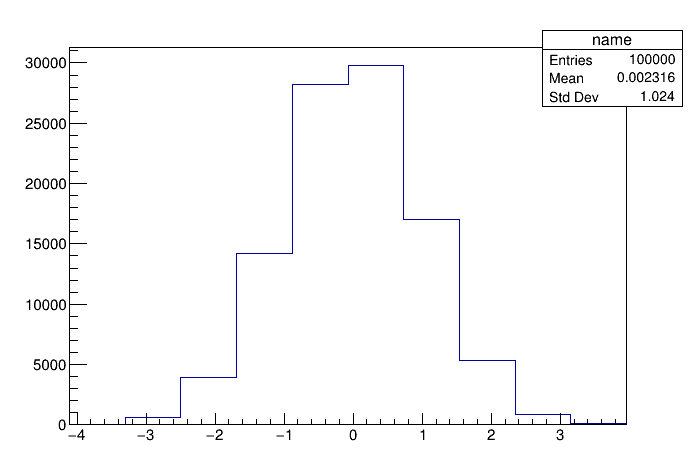

In [6]:
f = ROOT.TFile("tmp.root")                    # ROOT can read it, too
h = f.Get("name")
h.Draw()
c.Draw()

In [7]:
f = ROOT.TFile("tmp.root", "UPDATE")          # ROOT can add to the same file
h = ROOT.TH1D("another", "", 10, -5, 5)
for x in numpy.random.normal(0, 1, 100000):
    h.Fill(x)
h.Write()
f.Close()

In [8]:
f = uproot.open("tmp.root")
f["another"].show()

                 0                                                         35911
                 +-------------------------------------------------------------+
[-inf, -5) 0     |                                                             |
[-5, -4)   3     |                                                             |
[-4, -3)   133   |                                                             |
[-3, -2)   2109  |****                                                         |
[-2, -1)   13761 |***********************                                      |
[-1, 0)    34201 |**********************************************************   |
[0, 1)     33912 |**********************************************************   |
[1, 2)     13660 |***********************                                      |
[2, 3)     2116  |****                                                         |
[3, 4)     101   |                                                             |
[4, 5)     4     |          

uproot could become a clearinghouse for histograms from different libraries.

In [9]:
%matplotlib inline
import physt

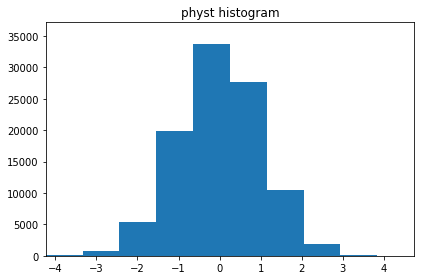

In [12]:
h = physt.h1(numpy.random.normal(0, 1, 100000), name="physt histogram")
h.plot()

In [13]:
f = uproot.recreate("tmp.root")
f["name"] = h

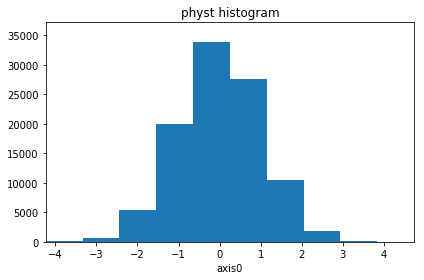

In [15]:
f = uproot.open("tmp.root")
f["name"].physt().plot()

In [16]:
f["name"].numpy()

(array([   57,   687,  5390, 19912, 33787, 27648, 10457,  1893,   164,
            5], dtype=int32),
 array([-4.23404024, -3.33718214, -2.44032405, -1.54346596, -0.64660786,
         0.25025023,  1.14710832,  2.04396641,  2.94082451,  3.8376826 ,
         4.73454069]))

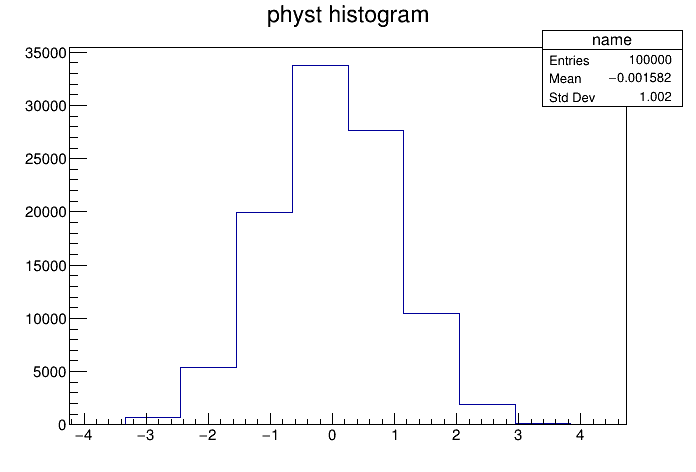

In [17]:
f = ROOT.TFile("tmp.root")
h = f.Get("name")
h.Draw()
c.Draw()

As well as new ways of looking at histograms.

In [19]:
f = uproot.open("tmp.root")
print(f["name"].hepdata())      # YAML format for the HEPData archival site

dependent_variables:
- header: {name: counts, units: null}
  qualifiers: []
  values:
  - errors:
    - {label: stat, symerror: 7.54983443527075}
    value: 57.0
  - errors:
    - {label: stat, symerror: 26.210684844162312}
    value: 687.0
  - errors:
    - {label: stat, symerror: 73.41661937191061}
    value: 5390.0
  - errors:
    - {label: stat, symerror: 141.10988625890107}
    value: 19912.0
  - errors:
    - {label: stat, symerror: 183.81240436923727}
    value: 33787.0
  - errors:
    - {label: stat, symerror: 166.27687752661222}
    value: 27648.0
  - errors:
    - {label: stat, symerror: 102.25947388873072}
    value: 10457.0
  - errors:
    - {label: stat, symerror: 43.508619835614184}
    value: 1893.0
  - errors:
    - {label: stat, symerror: 12.806248474865697}
    value: 164.0
  - errors:
    - {label: stat, symerror: 2.23606797749979}
    value: 5.0
independent_variables:
- header: {name: physt histogram, units: null}
  values:
  - {high: -3.3371821449215493, low: -4.23